# ML Solution in Trading

- Carolina Martínez Escalante
- Antonio Lomelí Ureña
- Enrique Tonatiuh Pérez Cortés Barba

## Problem Description

Machine learning offers a powerful alternative to traditional trading strategies by enabling models to learn patterns from historical market data and make data-driven decisions. 

Among these models, logistic regression is particularly valuable for predicting binary outcomes—such as whether an asset’s return will be positive or negative. 

Its interpretability, efficiency, and ability to handle high-dimensional data make it a common starting point in financial applications, especially when paired with technical indicators or engineered features to forecast short-term price movements.

## Objective

In this notebook we'll develope two ML pipelines using logistic regression. In the first one (Part 1) we'll create a generic logistic regression with standardized data, in the second case (Part 2) the data will be transformed using PCA, then optimize parameters using grid search and cross validation.

By comparing this two alternatives the we will reflect in the potential and business implications of ML algorithms for trading decission (open/close positions).

## Methodology

The data set of prices, indicators and "signal" (the target) is provided as `SPY_dataset_project.csv`. Furthermore, 6 indicators from technical analysis will be included.

- Overlay Indicators:
    - 6 day Simple Moving Average
    - 14 day Simple Moving Average
    - 5 day Rolling Volatility
    - Volume Change
- Oscilators:
    - Relative Strenght Index (14 day avg)
    - MACD 

Training and test data are divided in a 70/30 ratio, using sklearn module selection.

Then data is divided between numerical and categorical features. Numerical features are transformed using `Standard Scaler`, while categorical features are encoded using `OneHotEncoder`. The Principal Component Analysis (PCA) is made for case 2, using `PCA` library, all of the above from sklearn.

Classes are balanced using `SMOTE` library from imblearn, and the pipelines are created using this library as well. 

Finally, the linear regession model, cross validation, and grid search for parameter optimization are implemented using sklearn modules.

## ML Solutions


### Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Funcions for technical indicators
def rsi_indicator(prices: pd.Series, rolling:int=14):
    """
    Calculate the Relative Strength Index (RSI) for a given price series.

    Parameters:
    prices (pd.Series): A pandas Series containing the price data.
    rolling (int): The number of periods to use for the RSI calculation.

    Returns:
    pd.Series: A pandas Series containing the RSI values.
    """

    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(rolling).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(rolling).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

def macd_indicator(prices: pd.Series, upper: int = 12, lower: int = 26, signal: int = 9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a given price series.
    Parameters:
    prices (pd.Series): A pandas Series containing the price data.
    upper (int): The period for the short-term EMA.
    lower (int): The period for the long-term EMA.
    signal (int): The period for the signal line EMA.
    Returns:
    pd.Series: A pandas Series containing the MACD values.
    """

    ema_12 = prices.ewm(span=upper).mean()
    ema_26 = prices.ewm(span=lower).mean()

    macd = ema_12 - ema_26
    signal_ = macd.ewm(span=signal).mean()
    hist = macd - signal_
    return hist.fillna(0)

# Function to calculate metrics and display confusion matrix
def metrics(y_true, y_pred, pipeline: ImbPipeline, title: str = "Confusion Matrix"):
    accuracy_score_ = accuracy_score(y_true, y_pred)
    classification_report_ = classification_report(y_true, y_pred)
    classification_report_return = classification_report(y_true, y_pred, output_dict=True)

    print("Accuracy Train", accuracy_score_)
    print(f"Train Set Results: \n {classification_report_}" )
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    ax = disp.plot()
    ax.ax_.set_title(title)

    # Mostrar gráfico
    plt.show()
    
    
    return accuracy_score_, classification_report_return, disp

### Data Import and Indicators

In [3]:
data = pd.read_csv('SPY_dataset_project.csv', keep_default_na=False, na_values=[''," "])

# Creation of returns and indicators columns
data['r'] = np.log(data['Close'] / data['Close'].shift(1))
# Overlays
data["SMA_6"] = data["Close"].rolling(6).mean()
data["SMA_14"] = data["Close"].rolling(14).mean()
data["Vol_5"] = data["Close"].rolling(5).std()
data["Volume_change"] = data["Volume"].pct_change()
# Oscilators
data["RSI"] = rsi_indicator(data['Close'])
data["MACD"] = macd_indicator(data['Close'])

# Drop rows with NaN values
data.dropna(inplace=True)

data.head()

,Date,Close,Volume,return,signal,market_sentiment,recession_expectation,growing_sector,investor_type,news_impact,policy_uncertainty,r,SMA_6,SMA_14,Vol_5,Volume_change,RSI,MACD
13,2023-07-11,432.262634,64463800,0.006368,1,negative,low,health,retail,negative,medium,0.006348,431.039800,428.275253,1.940888,0.032354,63.361751,0.121508
14,2023-07-12,435.740570,91924500,0.008046,1,neutral,low,manufacturing,retail,neutral,medium,0.008014,431.402903,429.048440,2.953608,0.425986,67.476313,0.318742
15,2023-07-13,439.198975,72425200,0.007937,1,positive,high,finance,retail,neutral,low,0.007906,432.449880,429.959098,4.452668,-0.212123,69.379239,0.579032
16,2023-07-14,438.925415,69761800,-0.000623,0,neutral,high,manufacturing,retail,positive,high,-0.000623,434.016251,431.080499,4.211525,-0.036774,76.215334,0.682262
17,2023-07-17,440.449463,52680200,0.003472,1,neutral,low,health,retail,positive,low,0.003466,436.017375,432.434274,3.315603,-0.244856,81.865919,0.773490


### Train Test Split

In [4]:
# Divide the data into features and target variable
X = data[['Close', 'Volume', 'market_sentiment',
        'recession_expectation', 'growing_sector', 'investor_type',
        'news_impact', 'policy_uncertainty', 
        'r', 'SMA_6', 'SMA_14', 'Vol_5', 'Volume_change', 'RSI', 'MACD']]
y = data['signal']
# Make the split for the training and test sets of the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, stratify=y, random_state=42)

### Pre-processing

In [5]:
# Divide features by data type
categorical_features = ['market_sentiment',
                        'recession_expectation', 'growing_sector', 'investor_type',
                        'news_impact', 'policy_uncertainty']
numerical_features = ['Close', 'Volume',  
                      'r', 'SMA_6', 'SMA_14', 'Vol_5', 
                      'Volume_change', 'RSI', 'MACD']
# Create the pre processing pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('cat',OneHotEncoder(drop='first'),categorical_features),
        ('num',StandardScaler(),numerical_features)
    ]
)

### Part 1 (Generic LR)

In [6]:
# Build the pipeline with the preprocessor, SMOTE for oversampling, and the lr classifier
pipeline = ImbPipeline([
    ('preprocessor',preprocessor),
    ('sampler',SMOTE(random_state=42)),
    ('classifier',LogisticRegression()) # We won't change any parameters for the classifier
])

# Train the pipeline on the training data
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['market_sentiment',
                                                   'recession_expectation',
                                                   'growing_sector',
                                                   'investor_type',
                                                   'news_impact',
                                                   'policy_uncertainty']),
                                                 ('num', StandardScaler(),
                                                  ['Close', 'Volume', 'r',
                                                   'SMA_6', 'SMA_14', 'Vol_5',
                                                   'Volume_change', 'RSI',
                                                   'MACD'])])),
                ('sampler', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

Accuracy Train 0.9706744868035191
Train Set Results: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       144
           1       0.98      0.96      0.97       197

    accuracy                           0.97       341
   macro avg       0.97      0.97      0.97       341
weighted avg       0.97      0.97      0.97       341



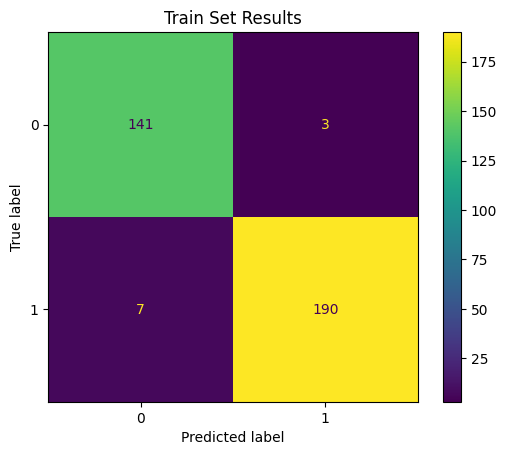

Accuracy Train 0.9727891156462585
Train Set Results: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        62
           1       0.99      0.96      0.98        85

    accuracy                           0.97       147
   macro avg       0.97      0.97      0.97       147
weighted avg       0.97      0.97      0.97       147



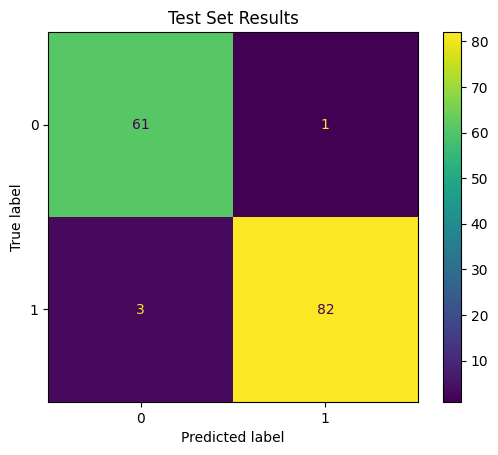

In [7]:
# Train Set
y_pred_train = pipeline.predict(X_train)
accuracy_train, metrics_report_train, cm_train = metrics(y_train, y_pred_train, pipeline, title = "Train Set Results")

# Test Set
y_pred_test = pipeline.predict(X_test)
accuracy_test, metrics_report_test, cm_test = metrics(y_test, y_pred_test, pipeline, title = "Test Set Results")

### Part 2 (PCA, Cross Validation and Grid Search)

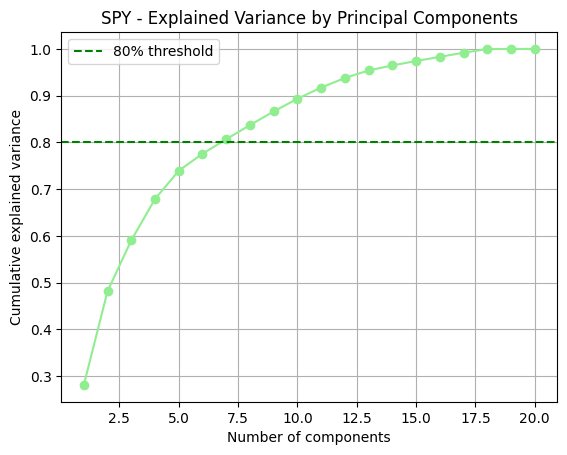

In [8]:
# Perform PCA Analysis to check the variance explained by each component
data_encoded = preprocessor.fit_transform(X) # Transform the entire dataset to include all features
pca = PCA() # Initialize PCA without specifying the number of components
pca_components = pca.fit_transform(data_encoded) # Fit PCA to the encoded data
explained_varanice_ratio = pca.explained_variance_ratio_
cum_VAR = np.cumsum(explained_varanice_ratio)
# Plot the explained variance ratio
plt.plot(range(1,len(cum_VAR)+1),cum_VAR, color='lightgreen', marker = "o")
plt.axhline(y = 0.8, color = "g", linestyle = "--", label = "80% threshold")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("SPY - Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()

It's observed that after 7 principal components we can explain >80% of the variance for the trading signal.

In [9]:
# Create the new pipleine with PCA
pca_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('pca', PCA(n_components=7)),  # Retain 80% of the variance by using the first 7 components
    ('classifier', LogisticRegression(random_state=42))
])

# Create the cross validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get the average cross-validation score
cv_scores = cross_val_score(pca_pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print(f"Average cross-validation F1 score: {cv_scores.mean():.4f} +- {cv_scores.std():.4f}")

# Create the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.linspace(0.1, 3, 30), # Regularization strength
    'classifier__solver': ['lbfgs','liblinear','saga','newton-cg'],  # Solvers for logistic regression
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None], 
            }

# Apply GridSearchCV to find the best parameters
pca_pipeline = GridSearchCV(pca_pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)

Average cross-validation F1 score: 0.9291 +- 0.0139


In [10]:
# Train the pipeline with PCA on the training data
pca_pipeline.fit(X_train, y_train)

c:\Users\tony_\Documents\Actividades ITESO\Microestructura\03-ML-Trading\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1050 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tony_\Documents\Actividades ITESO\Microestructura\03-ML-Trading\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tony_\Documents\Actividades ITESO\Microestructura\03-ML-Trading\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
        

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['market_sentiment',
                                                                          'recession_expectation',
                                                                          'growing_sector',
                                                                          'investor_type',
                                                                          'news_impact',
                                                                          'policy_uncertainty']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Close',
                                                                          'Volume',
                                                                          'r',
                                                                          'SMA_6',...
                                       ('pca', PCA(n_components=7)),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ]),
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 None],
                         'classifier__solver': ['lbfgs', 'liblinear', 'saga',
                                                'newton-cg']},
             scoring='f1')

Accuracy Train 0.9354838709677419
Train Set Results: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       144
           1       0.96      0.93      0.94       197

    accuracy                           0.94       341
   macro avg       0.93      0.94      0.93       341
weighted avg       0.94      0.94      0.94       341



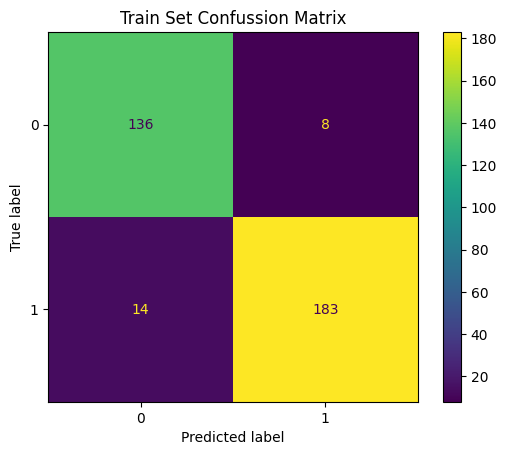

Accuracy Train 0.9659863945578231
Train Set Results: 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        62
           1       0.97      0.98      0.97        85

    accuracy                           0.97       147
   macro avg       0.97      0.96      0.97       147
weighted avg       0.97      0.97      0.97       147



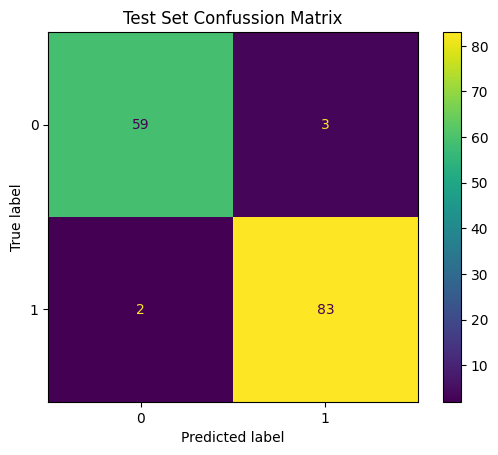

In [11]:
# Predict on the training set and evaluate the performance
y_pred_train = pca_pipeline.predict(X_train)
pca_accuracy_train, pca_metrics_report_train, cm_train = metrics(y_train, y_pred_train, pca_pipeline, title = "Train Set Confussion Matrix")

# Predict on the test set and evaluate the performance
y_pred_test = pca_pipeline.predict(X_test)
pca_accuracy_test, pca_metrics_report_test, cm_test = metrics(y_test, y_pred_test, pca_pipeline, title = "Test Set Confussion Matrix")


In [12]:
pca_pipeline.best_estimator_.get_params()['classifier'].get_params()  # Get the best parameters for the classifier

{'C': np.float64(1.5),
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Compare train and test metrics against model 1 (generic LR).

In [13]:
dic_metrics = [{'Name':"LR Train", 'data':metrics_report_train},{'Name':'LR Test', 'data':metrics_report_test},
               {'Name':'PCA LR Train', 'data':pca_metrics_report_train}, {'Name':'PCA LR Test', 'data':pca_metrics_report_test}] 
df_metrics_all = pd.DataFrame()

for dic_ in dic_metrics:
    df_report = pd.DataFrame(dic_['data']).T.iloc[:-1,:-1]
    df_report = round(df_report*100,2)
    df_report.columns = pd.MultiIndex.from_product([[dic_['Name']], df_report.columns.str.capitalize()])
    df_metrics_all = pd.concat([df_metrics_all, df_report], axis=1)

df_metrics_all

LR Train                   LR Test                 PCA LR Train  \
          Precision Recall F1-score Precision Recall F1-score    Precision   
0             95.27  97.92    96.58     95.31  98.39    96.83        90.67   
1             98.45  96.45    97.44     98.80  96.47    97.62        95.81   
accuracy      97.07  97.07    97.07     97.28  97.28    97.28        93.55   
macro avg     96.86  97.18    97.01     97.05  97.43    97.22        93.24   

                          PCA LR Test                  
          Recall F1-score   Precision Recall F1-score  
0          94.44    92.52       96.72  95.16    95.93  
1          92.89    94.33       96.51  97.65    97.08  
accuracy   93.55    93.55       96.60  96.60    96.60  
macro avg  93.67    93.42       96.62  96.40    96.51

Comparing both models, the first thing to notice is the lower accuracy of the second model (which includes PCA, cross-validation, and GridSearch) when compared to the baseline logistic regression model. Although the hyperparameters and solver differ between models, this drop in accuracy is expected when applying cross-validation, whose main goal is to prevent overfitting and improve the model’s generalization capability. Additionally, the PCA transformation contributes to this decrease in accuracy, as some information is inevitably lost when reducing dimensionality (retaining 80% of the explained variance).

The second key observation is the gap between training and test accuracy in the PCA based model, where accuracy is actually 3% higher on the test set. This suggests that the model generalizes better and is less prone to overfitting than the baseline model. Furthermore, the accuracy of the PCA + CV model before hyperparameter tuning was 92.9% on average with a standard deviation of 1.4%. After tuning via GridSearch, the model's accuracy increased by approximately half a standard deviation on the training set, and by more than two standard deviations on the test set, showing a meaningful improvement in generalization performance.

Considering the case context, where a "portfolio management" firm aims to open/buy positions (class 1) and close/sell them (class 0) based on model predictions, specially when trading in uncertain markets, it is more relevant to prioritize generalization over slightly higher in-sample accuracy. The second model, although marginally less accurate on the training set, provides a more stable and reliable performance on unseen data, making it a better candidate for deployment in real-world decision-making. Furthermore, the dimensionality reduction offered by PCA (from 20 to 7 features) enhances model parsimony and may facilitate the integration of this data into more complex downstream models or real-time trading pipelines.

## Part 3

Imagine you are managing a portfolio for a major financial firm, where:

- A prediction of 1 means Buy
- A prediction of 0 means Do Not Buy / Close Position

Reflect on:

- What is the impact of False Positives and False Negatives in this trading context?
    - In this context, the business impact of a False Positive is holding an asset when you shouldn’t, which may result in immediate or short-term losses for the firm. A False Negative, on the other hand, represents a missed opportunity, meaning the firm fails to open a position in a profitable asset—translating into opportunity costs and potential lost revenue.
- Which metric (precision, recall, F1-score, etc.) should the firm care about most, and why?
    - That depends on the firm’s trading strategy and market conditions.
        - If the firm operates in a highly competitive market or during bullish trends with strong growth, it should prioritize models with high recall, as these minimize False Negatives and help the firm capture more profitable opportunities.
        - Conversely, if the market is volatile or the strategy is risk-averse, the firm should favor high precision, reducing the chance of False Positives and limiting exposure to bad trades.
        -The F1-score provides a balanced perspective when both types of errors carry significant costs. It is especially useful in uncertain or mixed market conditions, helping the firm weigh the trade-offs between risk and reward in a more informed way.


### Conclusion

In trading, both technical indicators and machine learning (ML) models are designed to support decision-making, but they rely on fundamentally different processes. A technical analyst interpreting price charts and indicators engages in a subjective and variable thought process, influenced by a lot and complex variables (like context and emotion) that can't be really an input of a ML model. In contrast, an ML model follows a consistent and repeatable logic. It “learns” from historical data and transforms inputs through weighted combinations, dimensionality reduction, or decision paths, depending on the algorithm. While the model’s internal logic can be complex, many ML approaches, like Linear Regression, are relatively interpretable and can be explained and transparent.

One of the main advantages of machine learning is its scalability and objectivity. A human analyst may be limited to reviewing a handful of assets per hour, while a well-trained ML algorithm can analyze hundreds of assets in real time, capturing patterns or correlations that may be imperceptible to the human eye. Additionally, relying on a single technical indicator provides a narrow and often insufficient view of market dynamics, especially when compared to ML models that can integrate dozens of inputs simultaneously and still achieve accuracy levels above 90%.

That said, human intervention still plays a critical role. Analysts contribute intuition, macroeconomic awareness, and an understanding of market sentiment, elements that even the most sophisticated models may struggle to capture. Moreover, collecting and scaling these inputs across hundreds of assets or analysts is inherently difficult, as this type of knowledge is often implicit, unstructured, and highly context-dependent. Therefore, combining machine learning with technical analysis can offer the best of both worlds: the speed, consistency, and data-driven power of ML, alongside the judgment, adaptability, and strategic insight of human decision-makers trough technical indicators.